In [18]:
import numpy as np 
import pandas as pd 
import time
from tqdm import tqdm
import os
import cv2
import zipfile
from random import shuffle
from glob import glob

from tensorflow import keras
import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                          Dropout, Rescaling, RandomFlip, RandomRotation, BatchNormalization)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
 


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 


## Data preprocesing

In [2]:
# Произведем нормировку
rescale = Sequential([
  Rescaling(1./255)
])


In [3]:
# дополнительно проведем аугментацию для увеличения данных для тренировки
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
])

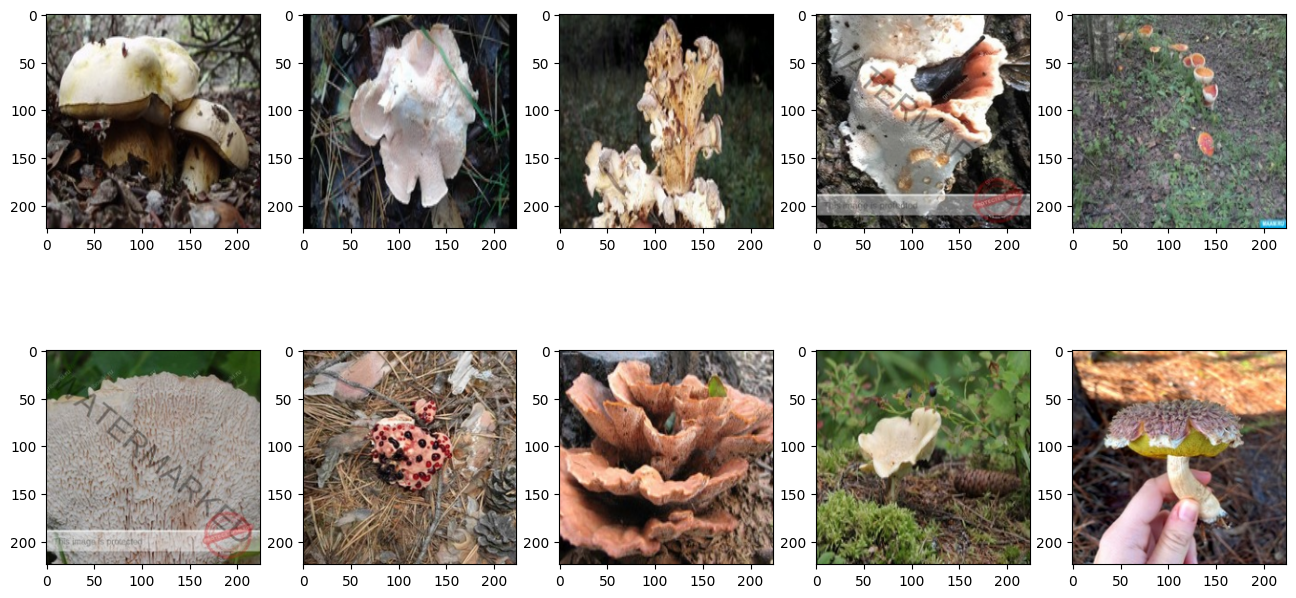

In [4]:
im_path=r'c:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Dataset\procecced\Гриб_Абортипорус'
os.chdir(im_path)

fig = plt.figure(figsize=(16, 8))
list2=glob('*.jpg')
for i, path in enumerate(list2[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
#    subplot.set_title('%s' %path.split('/')[1].split('.')[0])
#    img = cv2.imread(path)[...,::-1]
    imageBGR = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
    imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imageRGB, (224,224))
    plt.imshow(img)

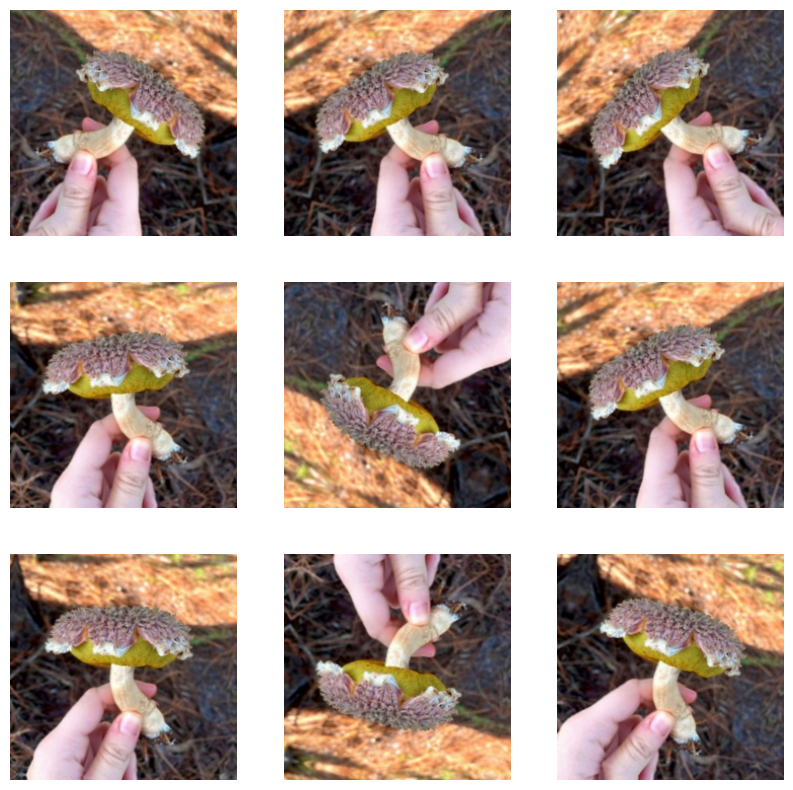

In [5]:
# вот что получится после аугментации
image = tf.expand_dims(img, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image =  np.array(data_augmentation(image),np.int32)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Загружаем предобученную модель

In [6]:
# base_model - объект класса keras.models.Model (Functional Model)
# Попробуем другую модель. т.к. модель vgg проигрывала resnet
IMG_SIZE = (240, 240)  # размер входного изображения сети
base_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                   pooling='avg',
                   weights='imagenet', classes=2)
for layer in base_model.layers:
        layer.trainable=False
  

## Добавляем 2 полносвязных слой для классификации

In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(2084, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(1042 , activation='softmax', kernel_regularizer=tf.keras.regularizers.l1(1e-4)))
# 23 млн параметров
model.summary()      

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2084)              4270116   
                                                                 
 dropout (Dropout)           (None, 2084)              0         
                                                                 
 batch_normalization (BatchN  (None, 2084)             8336      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1042)              2172570   
                                                      

In [8]:
# Создание генератора изображений
path = r'C:\\Users\\a.dubinets\\Desktop\\Обучение\\Mushrooms\\Dataset\\procecced'

#r'C:\\Users\\a.dubinets\\Desktop\\Обучение\\Mushrooms\\Dataset\\procecced'
img_height,img_width = 240, 240
batch_size = 100

datagen  = ImageDataGenerator(
#    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
    path,
    target_size=(240, 240),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')


validation_generator = datagen.flow_from_directory(
    path,
    target_size=(240, 240),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

class_names_train = list(train_generator.class_indices.keys())
class_names_validation = list(validation_generator.class_indices.keys())

train = pd.DataFrame(class_names_train, columns=['class'])
train.to_csv(r'C:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Result\class_2.csv', index=False, header=False)

print(class_names_train)

Found 98400 images belonging to 1042 classes.
Found 10414 images belonging to 1042 classes.
['Гриб_Абортипорус', 'Гриб_Агроцибе_стоповидный', 'Гриб_Агроцибе_эребия', 'Гриб_Алеврия_оранжевая', 'Гриб_Аллоклавария_пурпуровая', 'Гриб_Альбатреллус_гребенчатый', 'Гриб_Альбатреллус_краснеющий', 'Гриб_Альбатреллус_синепоровый', 'Гриб_Альбатреллус_сирени', 'Гриб_Альбатреллус_сливающийся_(Альбатреллус_сросшийся)', 'Гриб_Альбатреллус_тянь-шаньский', 'Гриб_Антракобия_маурилабра', 'Гриб_Аррения_лопатчатая', 'Гриб_Аскоболус_навозный', 'Гриб_Аскокорине_мясная', 'Гриб_Аскокорине_цилихниум', 'Гриб_Астерофора_дождевиковая', 'Гриб_Аурантипорус_расщепляющийся', 'Гриб_Аурикулариопсис_уховидный', 'Гриб_Аурикулярия_густоволосистая', 'Гриб_Аурикулярия_извилистая', 'Гриб_Аурикулярия_уховидная_(Иудино_ухо)', 'Гриб_Аурискальпиум_обыкновенный', 'Гриб_Баттаррея_веселковая', 'Гриб_Белонавозник_Бедхэма', 'Гриб_Белонавозник_Бирнбаума', 'Гриб_Белонавозник_Пилата', 'Гриб_Белопаутинник_луковичный', 'Гриб_Белосвинуха_гор

## Компилируем модель и запускаем обучение

In [9]:
model.compile(optimizer=Adam(learning_rate = 0.001, decay=0, beta_1=0.9, beta_2= 0.999, epsilon= 1e-07), 
              loss='categorical_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [10]:
# early_stop = EarlyStopping(monitor="val_loss",min_delta=0, patience=5,
#                           verbose=0, mode="min", baseline=None, restore_best_weights=True)
check = ModelCheckpoint(filepath='convnet.keras', save_best_only=True, monitor='val_loss')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
#val_samples = 50  # число изображений в валидационной выборке

#shuffle(train_files)  # перемешиваем обучающую выборку
#validation_data = next(fit_generator(train_files[:val_samples], val_samples))
#train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit_generator(train_generator,
                    steps_per_epoch=100,                    # число вызовов генератора за эпоху
                    epochs=100,                              # число эпох обучения
                    validation_data=validation_generator,
                    callbacks = [ check, learning_rate_reduction])

C:\Users\a.dubinets\AppData\Local\Temp\ipykernel_24224\136307894.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 1/100
100/100 [==============================] - 182s 2s/step - loss: 3.6329 - accuracy: 0.3763 - val_loss: 4.3546 - val_accuracy: 0.2734 - lr: 1.0000e-05
Epoch 2/100
100/100 [==============================] - 185s 2s/step - loss: 3.6340 - accuracy: 0.3734 - val_loss: 4.3619 - val_accuracy: 0.2709 - lr: 1.0000e-05
Epoch 3/100
100/100 [==============================] - 189s 2s/step - loss: 3.6380 - accuracy: 0.3703 - val_loss: 4.3435 - val_accuracy: 0.2691 - lr: 1.0000e-05
Epoch 4/100
100/100 [==============================] - 187s 2s/step - loss: 3.6377 - accuracy: 0.3729 - val_loss: 4.3451 - val_accuracy: 0.2703 - lr: 1.0000e-05
Epoch 5/100
100/100 [==============================] - 184s 2s/step - loss: 3.6205 - accuracy: 0.3771 - val_loss: 4.3455 - val_accuracy: 0.2662 - lr: 1.0000e-05
Epoch 6/100
100/100 [==============================] - 183s 2s/step - loss: 3.5721 - accuracy: 0.3772 - val_loss: 4.3569 - val_accuracy: 0.2712 - lr: 1.0000e-05
Epoch 7/100
100/100 [=============

Epoch 52/100
100/100 [==============================] - 181s 2s/step - loss: 3.5558 - accuracy: 0.3859 - val_loss: 4.3327 - val_accuracy: 0.2717 - lr: 1.0000e-05
Epoch 53/100
100/100 [==============================] - 183s 2s/step - loss: 3.5971 - accuracy: 0.3753 - val_loss: 4.3395 - val_accuracy: 0.2707 - lr: 1.0000e-05
Epoch 54/100
100/100 [==============================] - 182s 2s/step - loss: 3.5904 - accuracy: 0.3736 - val_loss: 4.3304 - val_accuracy: 0.2733 - lr: 1.0000e-05
Epoch 55/100
100/100 [==============================] - 182s 2s/step - loss: 3.6128 - accuracy: 0.3719 - val_loss: 4.3330 - val_accuracy: 0.2730 - lr: 1.0000e-05
Epoch 56/100
100/100 [==============================] - 182s 2s/step - loss: 3.5679 - accuracy: 0.3826 - val_loss: 4.3378 - val_accuracy: 0.2739 - lr: 1.0000e-05
Epoch 57/100
100/100 [==============================] - 181s 2s/step - loss: 3.5744 - accuracy: 0.3767 - val_loss: 4.3443 - val_accuracy: 0.2735 - lr: 1.0000e-05
Epoch 58/100
100/100 [======

In [56]:
m = model.evaluate(validation_generator) 

105/105 [==============================] - 97s 918ms/step - loss: 4.3257 - accuracy: 0.2715


In [18]:
model.save((r'C:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Result\mushrooms-ResNet50.hdf5')

In [11]:
model = load_model(r'C:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Result\mushrooms-ResNet50.hdf5')  # 27%

In [10]:
text = pd.DataFrame(model.summary())
text.to_csv(r'C:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Result\model_summary.csv', index=False, header=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2084)              4270116   
                                                                 
 dropout_1 (Dropout)         (None, 2084)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2084)             8336      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 1042)              2172570   
                                                      

In [11]:
# загружаем входное изображение и предобрабатываем
IMG_SIZE = (240, 240)
def load_image(path, target_size=IMG_SIZE):   # загружает картинку и делает ресайз
    imageBGR = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_COLOR)
    imageRGB = cv2.cvtColor(imageBGR , cv2.COLOR_BGR2RGB)
    img = cv2.resize(imageRGB, (240,240))
    return  img  # предобработка 
 

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [19]:
im_path=r'C:\Users\a.dubinets\Desktop\Обучение\Mushrooms\Dataset\test_image'
os.chdir(im_path)

test_files=glob(r'Желчный.jpg')
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

1/1 [==============================] - 0s 39ms/step


In [22]:
test_pred[0]

array([6.0286660e-05, 5.0733546e-05, 1.1071602e-04, ..., 1.0148055e-05,
       7.5635634e-04, 1.4496442e-06], dtype=float32)

In [18]:
intermediate_dictionary = {'proba':test_pred[0], 'class':class_names_train}  
df = pd.DataFrame(intermediate_dictionary)
df = df.sort_values(by='proba', ascending=False)
df.head(10)

,proba,class
183,0.203090,Гриб_Гиропорус_песчаный
182,0.070291,Гриб_Гиропорус_каштановый
32,0.063208,Гриб_Белый_гриб
404,0.058835,Гриб_Маслёнок_Беллини
271,0.033642,Гриб_Жёлчный_гриб
1015,0.027634,Гриб_Шампиньон_темно-красный
419,0.025801,Гриб_Мацутакэ
416,0.019843,Гриб_Маслёнок_рыжий
48,0.019171,Гриб_Болет_бронзовый_(Боровик_бронзовый)
403,0.016496,Гриб_Масленок_рыже-красный
